### Baseline experiment

Experiment to compare the 4 Optimization algorithms before trying to improve sparse search

In [13]:
import sys  
sys.path.insert(0, '../../')

import HPO
import pysgpp
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.metrics
from sklearn.model_selection import KFold
import numpy as np
import keras
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from numpy.random import seed
import random
import time
import os
import math
from matplotlib import cm
import matplotlib 

# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

random.seed(1)
seed(2)
tf.random.set_seed(3)

def reset_seeds():
    np.random.seed(1)
    random.seed(2)
    tf.random.set_seed(3)

VERBOSE = 0

SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

### Model creation function

In [14]:
def create_model(learning_rate=0.0001, input_dim=10, number_layers=1, neurons_per_layer=20):
    # create model
    model = Sequential()

    model.add(Dense(neurons_per_layer, input_shape=(input_dim,), activation='relu'))
    for _ in range(number_layers):
        model.add(Dense(neurons_per_layer, activation='relu'))
    model.add(Dense(1, activation=None))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model


### Hyperparameter space

In [15]:
hyperparameterspace = {
    'epochs': ["interval-int", 1, 40],
    #'batch_size': ["interval-int", 1, 200],
    'learning rate': ["interval-log", 1e-10, 1e-1],
    #'number_layers': ["interval-int", 1, 20],
    #'neurons_per_layer': ["interval-int", 1, 50]
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste

### Optimization

In [16]:
def visualize(points, adaptivity, alternative):
    x_values = []
    y_values = []
    z_values = []

    print(len(points))

    for i in range(len(points)):    
        x_values.append(points[i].get_coordinates()[0])
        y_values.append(np.log10(points[i].get_coordinates()[1]))
        z_values.append(points[i].get_value())


    fig = plt.figure()
    ax = plt.axes()
    surface = plt.scatter(x_values, y_values, c=z_values, cmap="plasma")
    plt.scatter(points[0].get_coordinates()[0], points[0].get_coordinates()[1], c="white", marker="x")

    plt.colorbar(surface)
    # plt.gca().set_aspect("equal")

    # plt.savefig("./Alternative_"+str(alternative)+"_adapt_"+str(adaptivity)+".pgf",bbox_inches='tight' )

    plt.show()

100


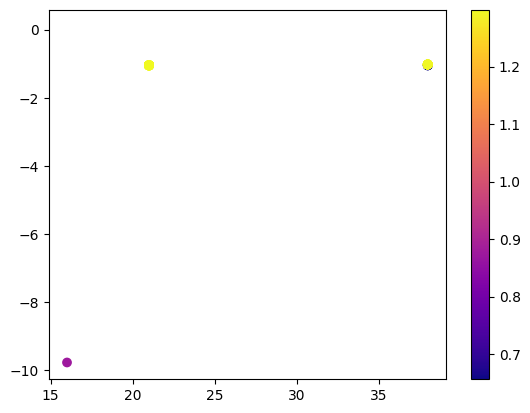

100


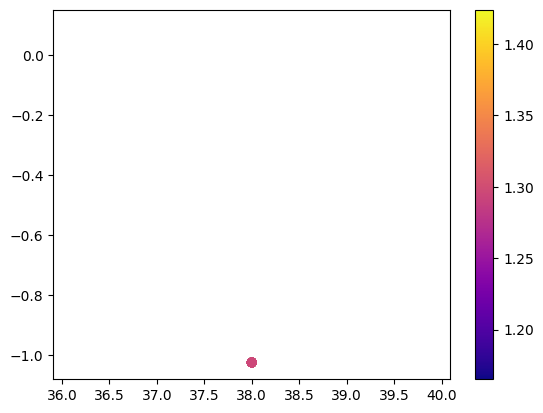

98


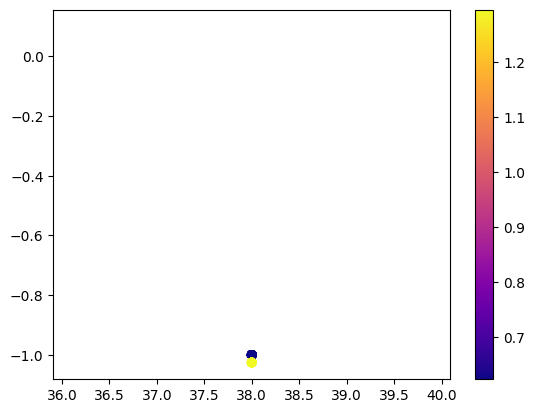

100


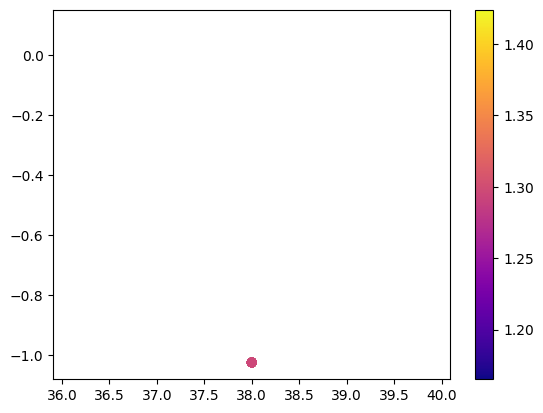

100


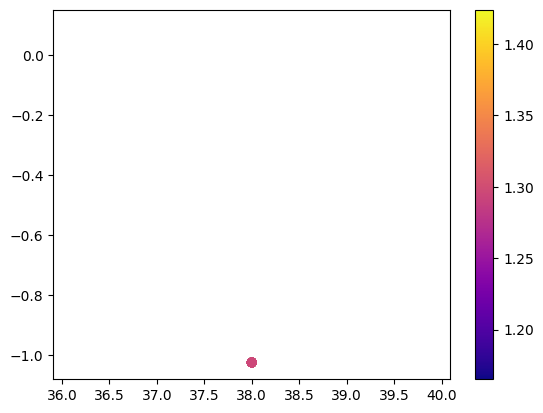

KeyboardInterrupt: 

In [17]:

################## MODEL AND FUNCTION DEFINITION ####################
CV = 2
dataset = HPO.Dataset(task_id=233211)

def evaluate_model(epochs, batch_size, learning_rate, number_of_layers, neurons_per_layer, deterministic=True):

    kfold = KFold(n_splits=CV)

    split = (kfold.split(dataset.get_X(), dataset.get_Y()))

    values = []

    numeric_features = [not x for x in dataset.get_categorical_indicator()]
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())]
    )

    categorical_transformer = Pipeline(
        steps=[
            ("encoder", OneHotEncoder(
                handle_unknown="infrequent_if_exist", sparse_output=False)),
            # ("selector", SelectPercentile(chi2, percentile=50)),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer,
                dataset.get_categorical_indicator()),
        ]
    )

    for i, (train_index, test_index) in enumerate(split):

        if deterministic:
            reset_seeds()

        X_train = dataset.get_X()[train_index]
        Y_train = dataset.get_Y()[train_index]

        X_val = dataset.get_X()[test_index]
        Y_val = dataset.get_Y()[test_index]

        preprocessor.fit(X_train, Y_train)

        X_train = preprocessor.transform(X_train)
        X_val = preprocessor.transform(X_val)

        regressor = KerasRegressor(model=create_model,
                                    learning_rate=learning_rate,
                                    input_dim=len(
                                        X_train[0]),
                                    number_layers=number_of_layers,
                                    neurons_per_layer=neurons_per_layer,
                                    verbose=0)

        regressor = TransformedTargetRegressor(regressor=regressor,
                                                transformer=StandardScaler())

        regressor.fit(X_train, Y_train, epochs=int(epochs),
                        batch_size=int(batch_size), shuffle=False)

        Y_predicted = regressor.predict(X_val)
        # error = sklearn.metrics.mean_absolute_error(Y_predicted, Y_val)
        error = sklearn.metrics.mean_absolute_percentage_error(
            Y_predicted, Y_val)
        values.append(error)

        del regressor
        K.clear_session()

    result = sum(values)/len(values)
    return result

def function(coordinates):
        
    return evaluate_model(epochs=coordinates[0], batch_size=100, learning_rate=coordinates[1], number_of_layers=1, neurons_per_layer=30)


class ExampleFunction(pysgpp.ScalarFunction):

    def __init__(self):
        super(ExampleFunction, self).__init__(
            len(hyperparameterspace.keys()))

    def eval(self, x):
        epochs = int(HPO.from_standard(
            hyperparameterspace_special["epochs"][0], hyperparameterspace_special["epochs"][1], x[0]))

        batch_size = 100 

        model_learning_rate = HPO.from_standard_log(
            hyperparameterspace_special["learning rate"][0], hyperparameterspace_special["learning rate"][1], x[1])

        number_of_layers = 1

        neurons_per_layer = 30

        return evaluate_model(epochs, batch_size, model_learning_rate, number_of_layers, neurons_per_layer)

optimizer = HPO.IterativeRandomOptimization(HPO.Dataset([],[]), function, 
                                                    hyperparameterspace, 100, 0, 0.15, 
                                                    init_points=10*len(hyperparameterspace.keys()), 
                                                    alternative=0, ref_per_step=4)
points = optimizer.fit()

visualize(points, 1, 2)

optimizer = HPO.IterativeRandomOptimization(HPO.Dataset([],[]), function, 
                                                    hyperparameterspace, 100, 0, 0.15, 
                                                    init_points=8*len(hyperparameterspace.keys()), 
                                                    alternative=1, ref_per_step=4)
points = optimizer.fit()

visualize(points, 1, 2)

optimizer = HPO.IterativeRandomOptimization(HPO.Dataset([],[]), function, 
                                                    hyperparameterspace, 100, 0, 0.15, 
                                                    init_points=7*len(hyperparameterspace.keys()), 
                                                    alternative=2, ref_per_step=4)
points = optimizer.fit()

visualize(points, 1, 2)


optimizer = HPO.IterativeRandomOptimization(HPO.Dataset([],[]), function, 
                                                    hyperparameterspace, 100, 0, 0.35, 
                                                    init_points=10*len(hyperparameterspace.keys()), 
                                                    alternative=0, ref_per_step=4)
points = optimizer.fit()

visualize(points, 1, 2)

optimizer = HPO.IterativeRandomOptimization(HPO.Dataset([],[]), function, 
                                                    hyperparameterspace, 100, 0, 0.35, 
                                                    init_points=8*len(hyperparameterspace.keys()), 
                                                    alternative=1, ref_per_step=4)
points = optimizer.fit()

visualize(points, 1, 2)

optimizer = HPO.IterativeRandomOptimization(HPO.Dataset([],[]), function, 
                                                    hyperparameterspace, 100, 0, 0.35, 
                                                    init_points=7*len(hyperparameterspace.keys()), 
                                                    alternative=2, ref_per_step=4)
points = optimizer.fit()

visualize(points, 1, 2)

optimizer = HPO.IterativeRandomOptimization(HPO.Dataset([],[]), function, 
                                                    hyperparameterspace, 100, 0, 0.55, 
                                                    init_points=10*len(hyperparameterspace.keys()), 
                                                    alternative=0, ref_per_step=4)
points = optimizer.fit()

visualize(points, 1, 2)

optimizer = HPO.IterativeRandomOptimization(HPO.Dataset([],[]), function, 
                                                    hyperparameterspace, 100, 0, 0.55, 
                                                    init_points=8*len(hyperparameterspace.keys()), 
                                                    alternative=1, ref_per_step=4)
points = optimizer.fit()

visualize(points, 1, 2)

optimizer = HPO.IterativeRandomOptimization(HPO.Dataset([],[]), function, 
                                                    hyperparameterspace, 100, 0, 0.55, 
                                                    init_points=7*len(hyperparameterspace.keys()), 
                                                    alternative=2, ref_per_step=4)
points = optimizer.fit()

visualize(points, 1, 2)

optimizer = HPO.IterativeRandomOptimization(HPO.Dataset([],[]), function, 
                                                    hyperparameterspace, 100, 0, 0.75, 
                                                    init_points=10*len(hyperparameterspace.keys()), 
                                                    alternative=0, ref_per_step=4)
points = optimizer.fit()

visualize(points, 1, 2)

optimizer = HPO.IterativeRandomOptimization(HPO.Dataset([],[]), function, 
                                                    hyperparameterspace, 100, 0, 0.75, 
                                                    init_points=8*len(hyperparameterspace.keys()), 
                                                    alternative=1, ref_per_step=4)
points = optimizer.fit()

visualize(points, 1, 2)

optimizer = HPO.IterativeRandomOptimization(HPO.Dataset([],[]), function, 
                                                    hyperparameterspace, 100, 0, 0.75, 
                                                    init_points=7*len(hyperparameterspace.keys()), 
                                                    alternative=2, ref_per_step=4)
points = optimizer.fit()

visualize(points, 1, 2)

optimizer = HPO.IterativeRandomOptimization(HPO.Dataset([],[]), function, 
                                                    hyperparameterspace, 100, 0, 0.95, 
                                                    init_points=10*len(hyperparameterspace.keys()), 
                                                    alternative=0, ref_per_step=4)
points = optimizer.fit()

visualize(points, 1, 2)

optimizer = HPO.IterativeRandomOptimization(HPO.Dataset([],[]), function, 
                                                    hyperparameterspace, 100, 0, 0.95, 
                                                    init_points=8*len(hyperparameterspace.keys()), 
                                                    alternative=1, ref_per_step=4)
points = optimizer.fit()

visualize(points, 1, 2)

optimizer = HPO.IterativeRandomOptimization(HPO.Dataset([],[]), function, 
                                                    hyperparameterspace, 100, 0, 0.95, 
                                                    init_points=7*len(hyperparameterspace.keys()), 
                                                    alternative=2, ref_per_step=4)
points = optimizer.fit()

visualize(points, 1, 2)

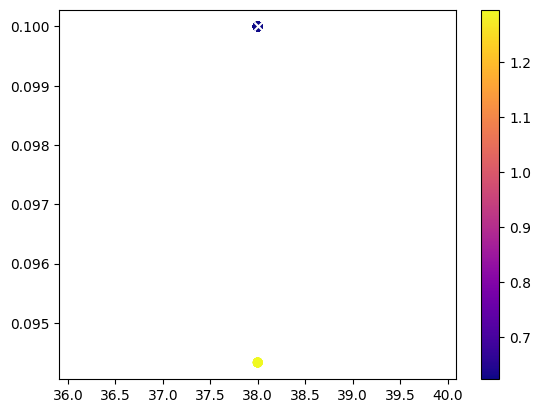

[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.1]
[38, 0.09433292446693879]
[38, 0.09433292446693879]
[38, 0.09433292446693879]
[38, 0.09433292446693879]
[38, 0.09433292446693879]
[38, 0.09433292446693879]
[38,

In [ ]:
def visualize(points, adaptivity, alternative):
    x_values = []
    y_values = []
    z_values = []

    for i in range(len(points)):    
        x_values.append(points[i].get_coordinates()[0])
        y_values.append(points[i].get_coordinates()[1])
        z_values.append(points[i].get_value())


    fig = plt.figure()
    ax = plt.axes()
    surface = plt.scatter(x_values, y_values, c=z_values, cmap="plasma")
    plt.scatter(points[0].get_coordinates()[0], points[0].get_coordinates()[1], c="white", marker="x")

    plt.colorbar(surface)
    # plt.gca().set_aspect("equal")

    # plt.savefig("./Alternative_"+str(alternative)+"_adapt_"+str(adaptivity)+".pgf",bbox_inches='tight' )

    plt.show()

visualize(points, 1, 2)

for i in range(len(points)):    
    print(points[i].get_coordinates())